*#*

<center>
    <h3>Library</h3>
</center>

In [1]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [3]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str) -> str:
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str) -> str:
    txt = ""
    for w in word_tokenize(text):
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str) -> str:
    txt = ""
    for w in pos_tag(word_tokenize(text)):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int) -> str:
    txt = ""
    elements = word_tokenize(text)
    n = len(elements)
    for i, w in enumerate(elements):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str) -> str:
    txt = ""
    for s in sent_tokenize(text):
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> (sp.sparse.csr_matrix, TfidfVectorizer):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> (sp.sparse.csr_matrix, CountVectorizer):
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> (sp.sparse.csr_matrix, TfidfVectorizer):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> (sp.sparse.csr_matrix, CountVectorizer):
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> (float, float, float):
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> dict[str: list([float, float])]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: dict[str: list([float, float])]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Exploration</h3>
</center>

In [4]:
df = pd.read_json('../data/Amazon_GroceryandGourmetFood.json', lines=True)

In [5]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly l...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super p...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was ev...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of m...,Topper,1397606400,NaN,NaN,NaN


In [6]:
df.describe()

,overall,unixReviewTime
count,5.074160e+06,5.074160e+06
mean,4.314708e+00,1.446592e+09
std,1.249303e+00,6.227839e+07
min,1.000000e+00,9.613728e+08
25%,4.000000e+00,1.416096e+09
50%,5.000000e+00,1.456790e+09
75%,5.000000e+00,1.491782e+09
max,5.000000e+00,1.538870e+09


In [7]:
df.isnull().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
reviewerName          355
reviewText           2883
summary              1327
unixReviewTime          0
vote              4414688
image             5003225
style             2798836
dtype: int64

<AxesSubplot:xlabel='overall'>

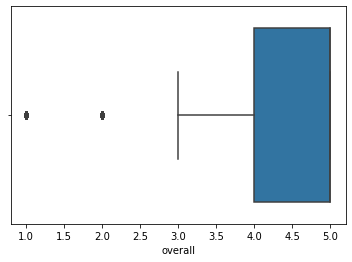

In [74]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

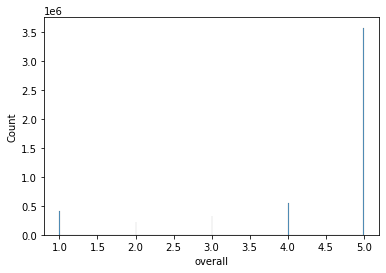

In [75]:
sns.histplot(df['overall'])

In [8]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,Very pleased with my purchase. Looks exactly l...,5
1,Very nicely crafted but too small. Am going to...,4
2,still very pretty and well made...i am super p...,4
3,"I got this for our wedding cake, and it was ev...",5
4,It was just what I want to put at the top of m...,4


In [9]:
dfdata.fillna("", inplace=True)

In [10]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [11]:
if len(dfdata['overall'].unique()) != 3:
    dfdata['overallOri'] = dfdata['overall']
dfdata['overall'] = dfdata['overallOri'].apply(lambda x: "Positive" if x > 3 else "Negative" if x < 3 else "Neutral")

In [76]:
dfdata['overall']

0          Positive
1          Positive
2          Positive
3          Positive
4          Positive
             ...   
5074155    Positive
5074156     Neutral
5074157    Positive
5074158    Positive
5074159    Positive
Name: overall, Length: 5074160, dtype: object

<AxesSubplot:xlabel='overall', ylabel='Count'>

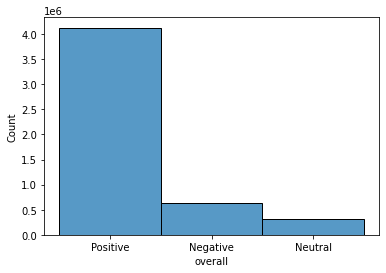

In [78]:
sns.histplot(dfdata['overall'])

In [12]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

<AxesSubplot:xlabel='overall', ylabel='Count'>

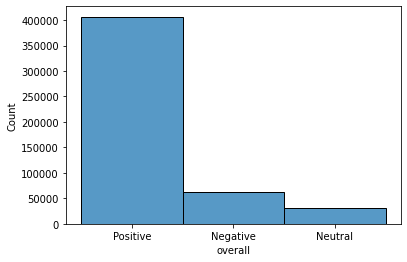

In [72]:
sns.histplot(dfdataMain['overall'])

In [13]:
dfdataMain.shape

(500000, 3)

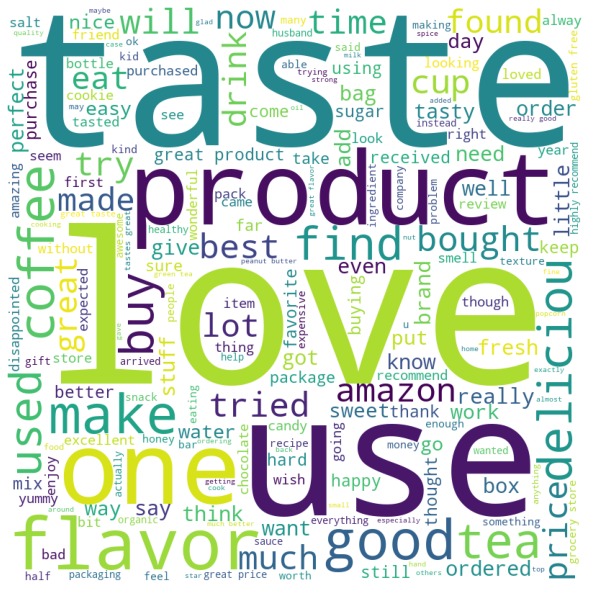

In [82]:
# show wordcloud for the overall text
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + tdf['reviewText'].lower()

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

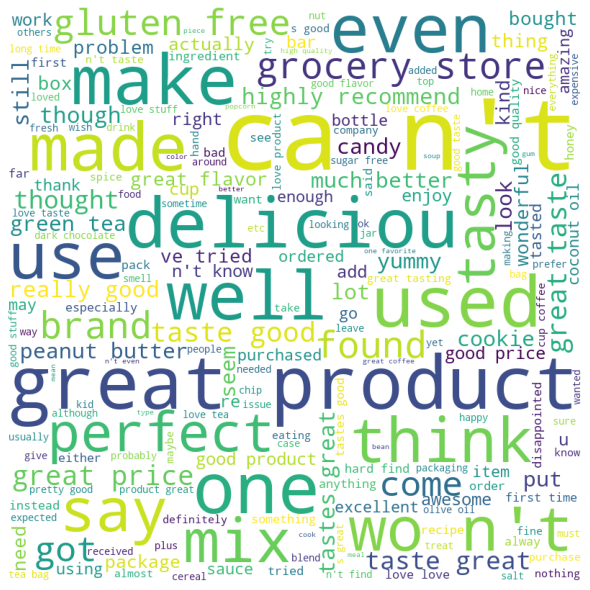

In [83]:
# show wordcloud for the overall text after removing stop words
words = ''
for i, tdf in dfdataMain.iterrows():
    words += ' ' + pipe_removeStopWords(tdf['reviewText'].lower())

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

<center>
    <h3>Process</h3>
</center>

In [14]:
# for training & testing
target_n = 450 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [15]:
# for validation
target_n = 45 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [16]:
# for validation training & testing
target_n = 40 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

In [17]:
dfdataValidTrain.shape

(40000, 3)

In [18]:
# validation for processing

In [19]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

277950058

In [20]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

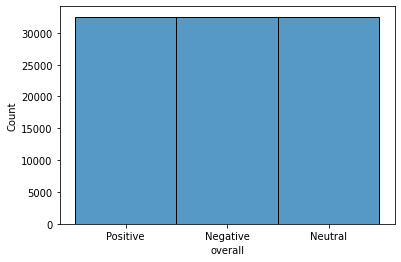

In [79]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [21]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

In [22]:
# base nb model
nb_model = MultinomialNB()

Correlation last 3: 0.7407
Gradient last 3: 0.0021


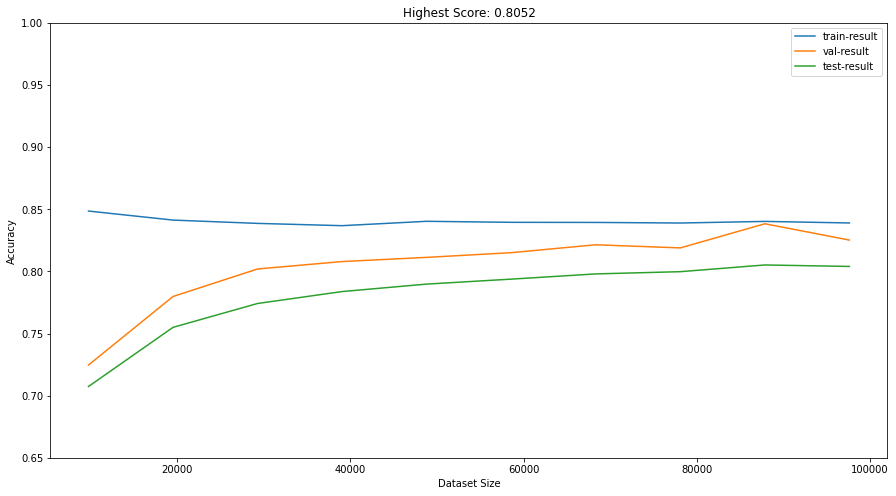

In [24]:
# pipeline 0: no preprocessing

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7407
Gradient last 3: 0.0021


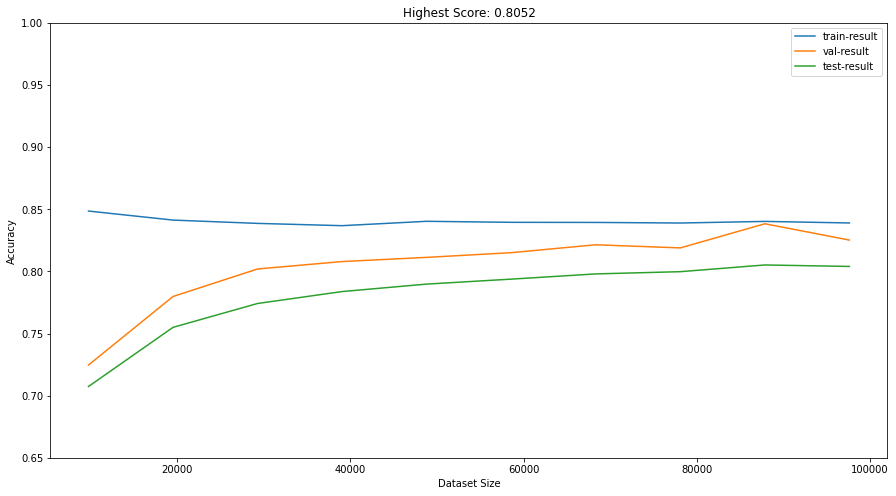

In [25]:
# pipeline 1: cleaningText
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7981
Gradient last 3: 0.0039


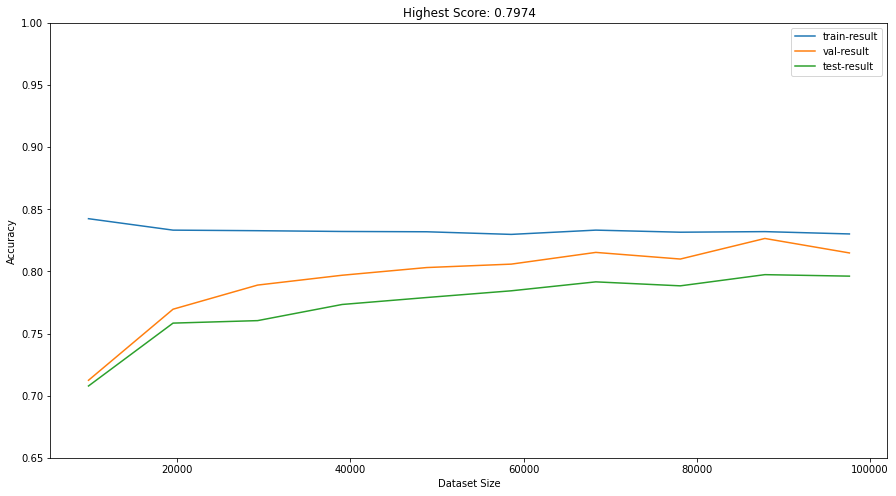

In [26]:
# pipeline 2: cleaningText -> removeStopWords
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_removeStopWords(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9762
Gradient last 3: 0.0026


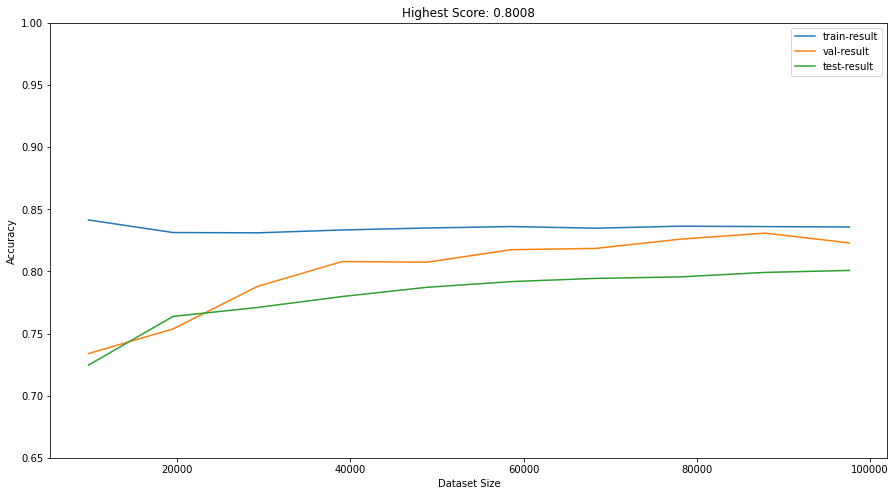

In [336]:
# pipeline 3: cleaningText -> lemmatized
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7747
Gradient last 3: 0.0029


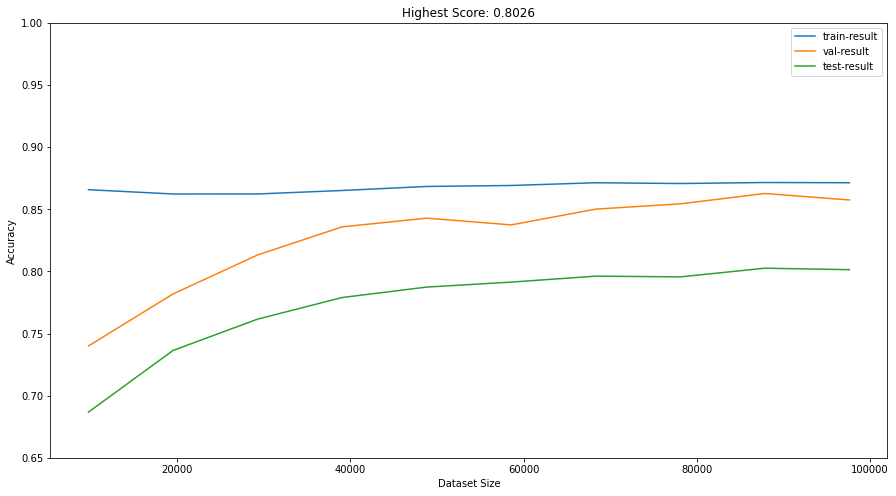

In [337]:
# pipeline 4: cleaningText -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8780
Gradient last 3: 0.0036


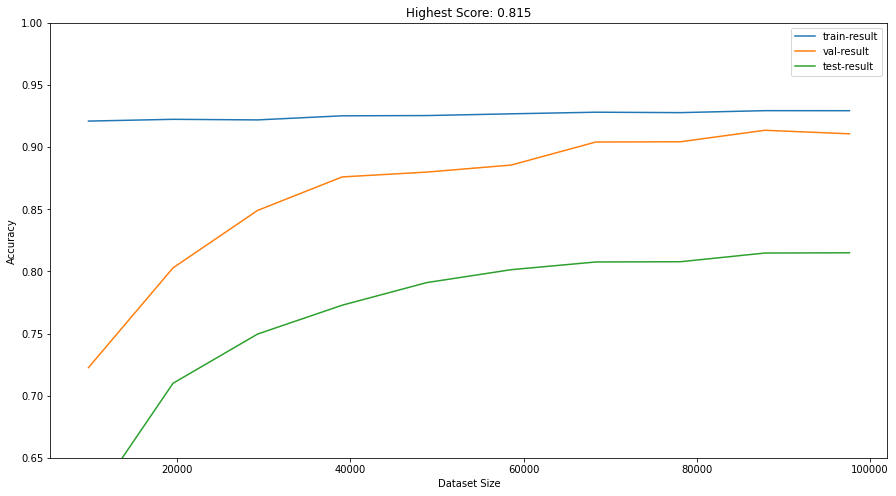

In [338]:
# pipeline 5: cleaningText -> normalized 10 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 10)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.7286
Gradient last 3: 0.0035


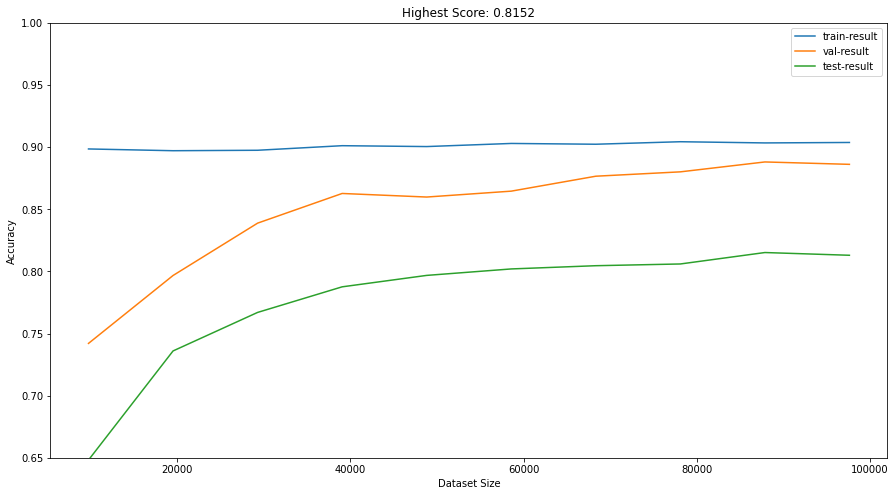

In [339]:
# pipeline 6: cleaningText -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.6647
Gradient last 3: 0.0019


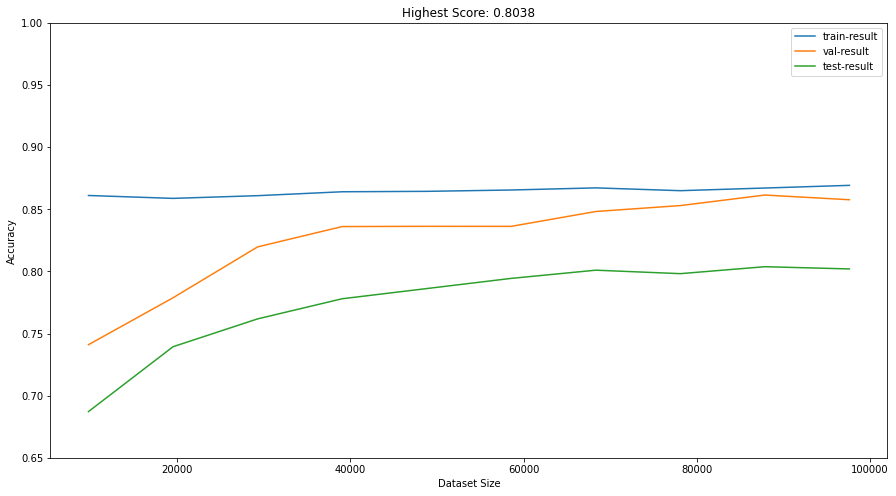

In [340]:
# pipeline 7: cleaningText -> lemmatized -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8447
Gradient last 3: 0.0041


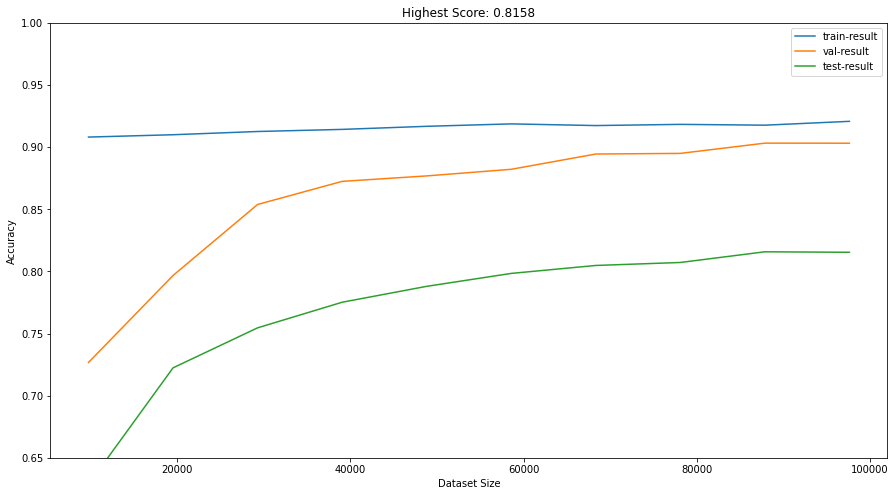

In [341]:
# pipeline 8: cleaningText -> lemmatized -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8059
Gradient last 3: 0.0022


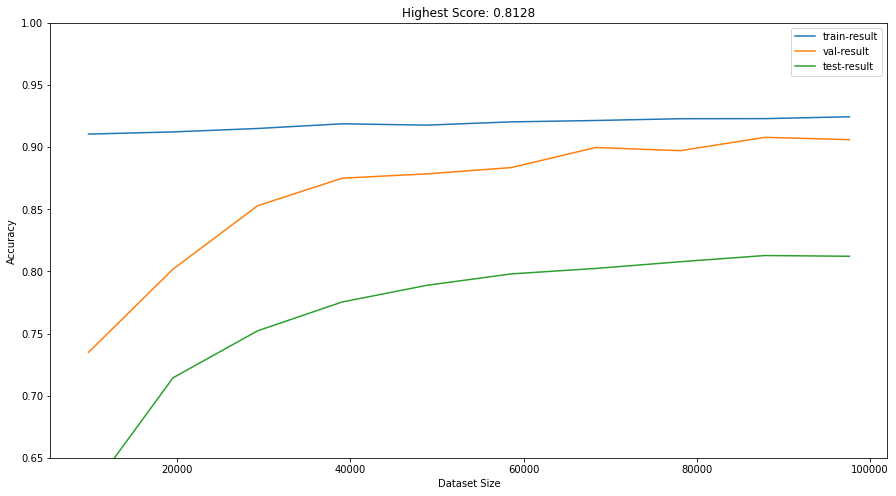

In [342]:
# pipeline 9: cleaningText -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5411
Gradient last 3: 0.0026


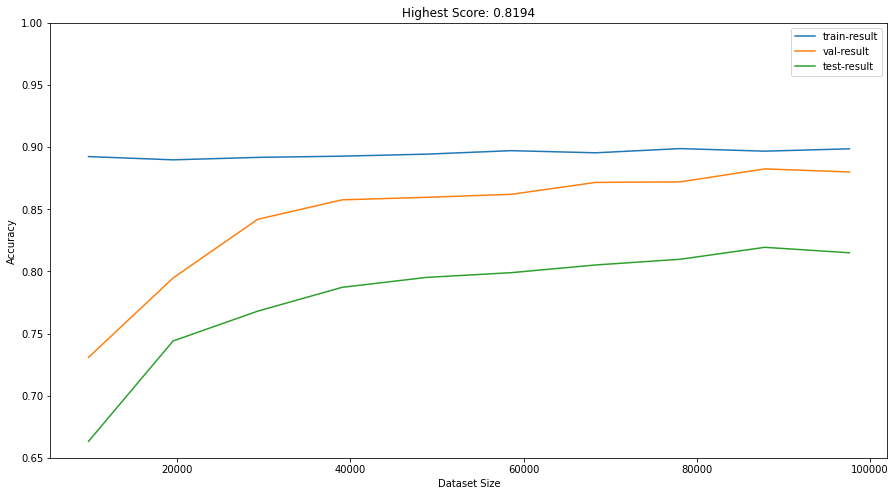

In [343]:
# pipeline 10: cleaningText -> lemmatized -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [177]:
# test on top 3

In [309]:
dfdataValid.shape

(45000, 3)

              precision    recall  f1-score   support

    Positive       0.96      0.92      0.94     38281
     Neutral       0.19      0.40      0.26      1384
    Negative       0.65      0.68      0.67      5335

    accuracy                           0.87     45000
   macro avg       0.60      0.66      0.62     45000
weighted avg       0.90      0.87      0.88     45000



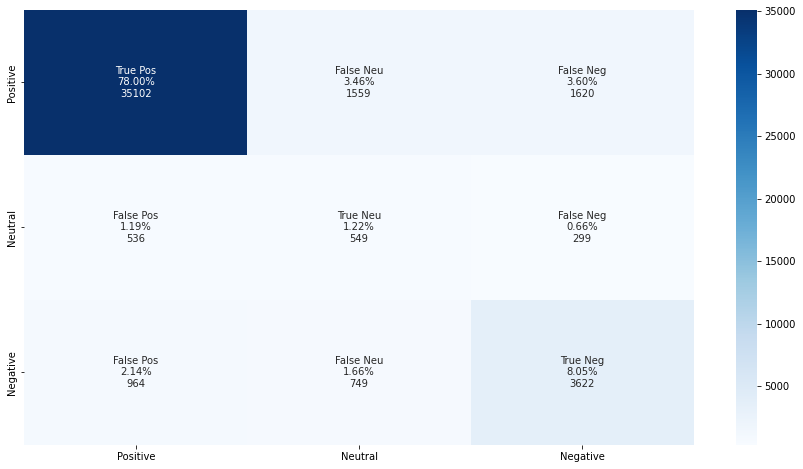

In [311]:
tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.91      0.94     39117
     Neutral       0.11      0.44      0.18       733
    Negative       0.64      0.69      0.67      5150

    accuracy                           0.88     45000
   macro avg       0.58      0.68      0.60     45000
weighted avg       0.92      0.88      0.90     45000



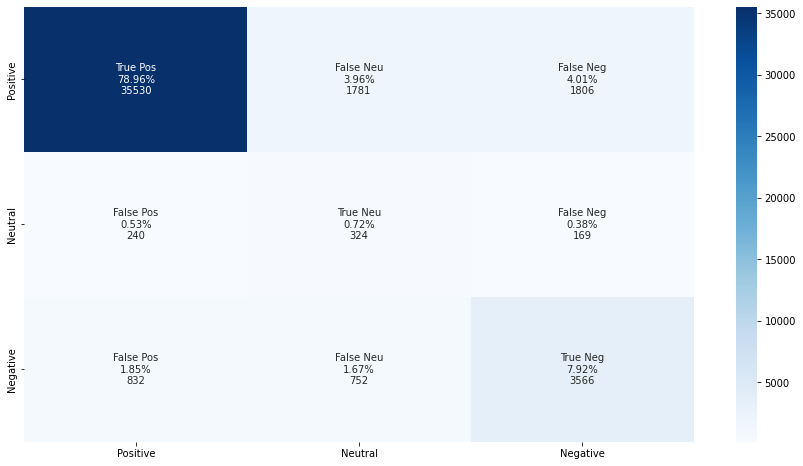

In [312]:
# option 1: cleaningText -> lemmatized -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.98      0.90      0.94     39833
     Neutral       0.06      0.47      0.11       383
    Negative       0.61      0.71      0.66      4784

    accuracy                           0.88     45000
   macro avg       0.55      0.69      0.57     45000
weighted avg       0.93      0.88      0.90     45000



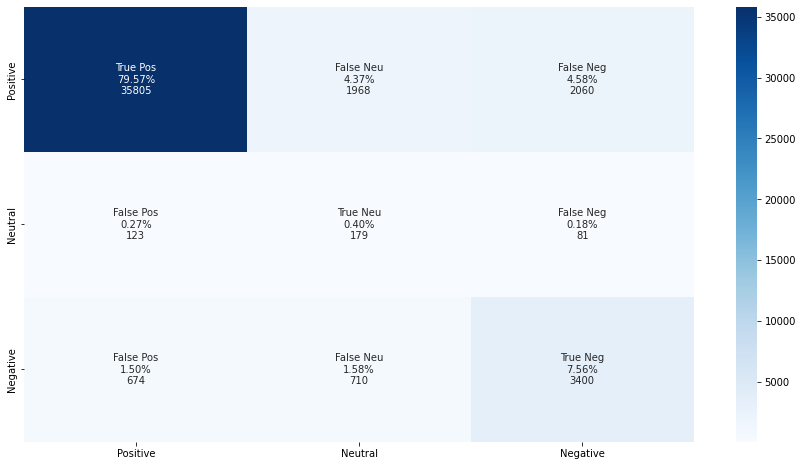

In [313]:
# option 2: cleaningText -> lemmatized -> addPos -> normalized 5 position
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5)
    return txt

tdf1 = dfdataTrainSub.copy()
tdf2 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

              precision    recall  f1-score   support

    Positive       0.97      0.91      0.94     43118
     Neutral       0.13      0.43      0.19       914
    Negative       0.67      0.69      0.68      5968

    accuracy                           0.88     50000
   macro avg       0.59      0.68      0.60     50000
weighted avg       0.92      0.88      0.89     50000



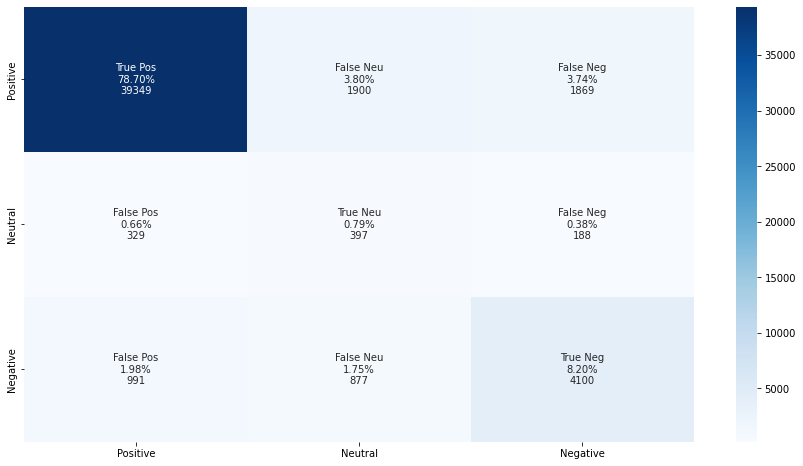

In [314]:
# option 3: cleaningText -> lemmatized -> addPos
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_addPos(txt)
    return txt

tdf1 = dfdataTrain.copy()
tdf2 = dfdataTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
nb_model.fit(xArr, yArr)
yHat = nb_model.predict(testXArr)
show_result(yHat, testYArr)

In [203]:
# test feature extraction

In [344]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt
    
tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

Correlation last 3: 0.5411
Gradient last 3: 0.0026


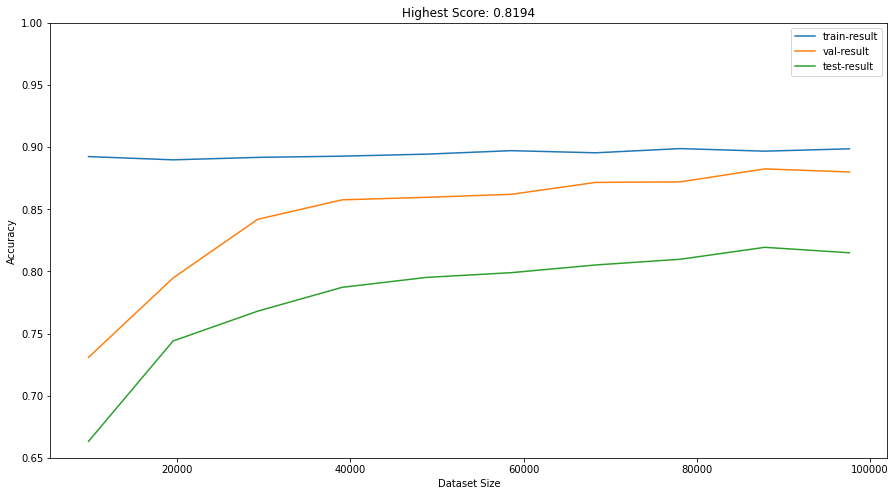

In [345]:
# feature 1: bow uni

xArr, featureModel = feature_bowUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.8787
Gradient last 3: 0.0034


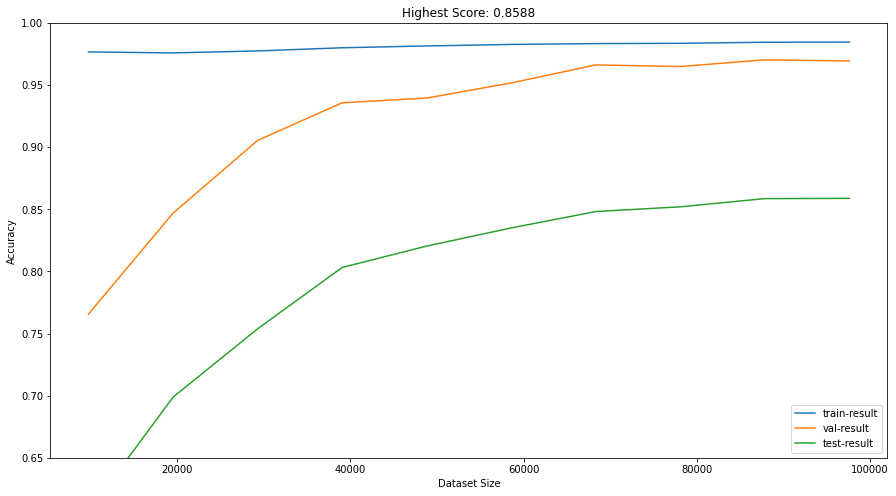

In [346]:
# feature 2: bow unibi

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9344
Gradient last 3: 0.0053


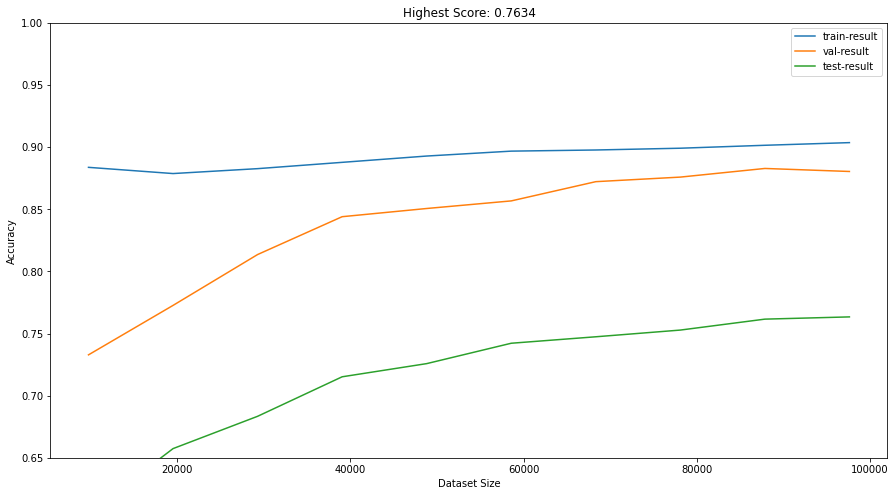

In [347]:
# feature 3: tfidf uni

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9916
Gradient last 3: 0.0124


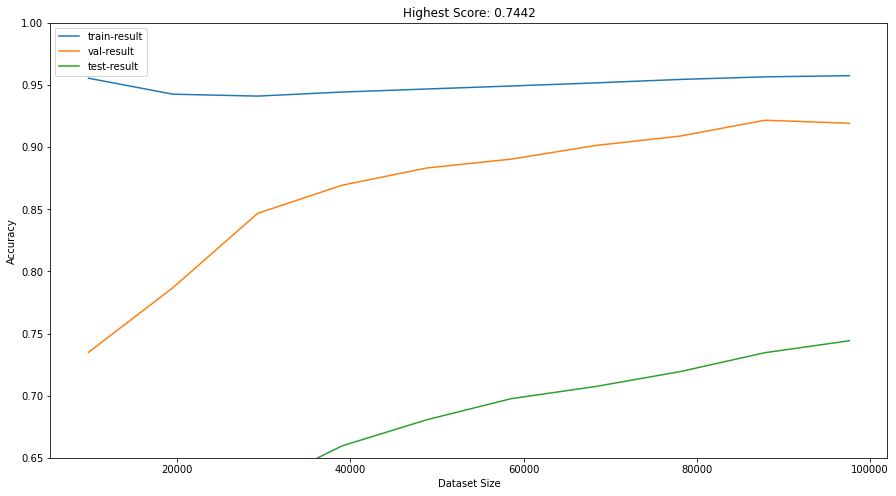

In [348]:
# feature 4: tfidf unibi

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'])
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5411
Gradient last 3: 0.0026


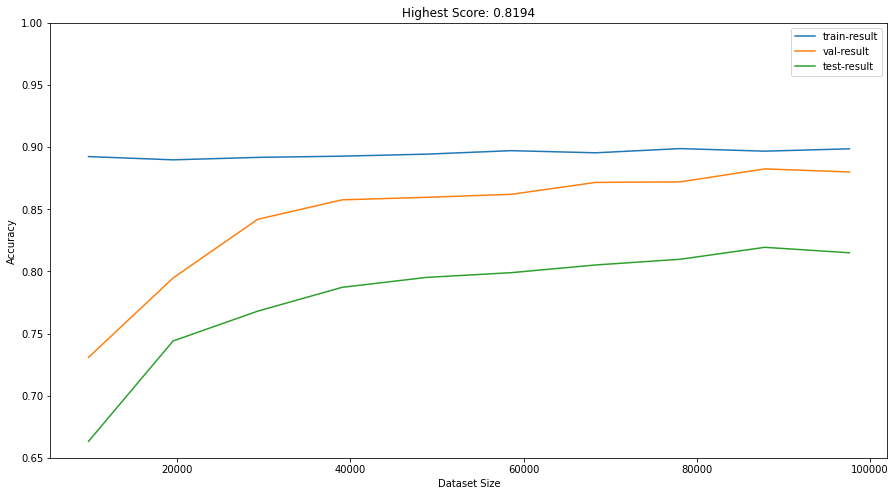

In [349]:
# feature 5: bow uni 50k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5576
Gradient last 3: 0.0019


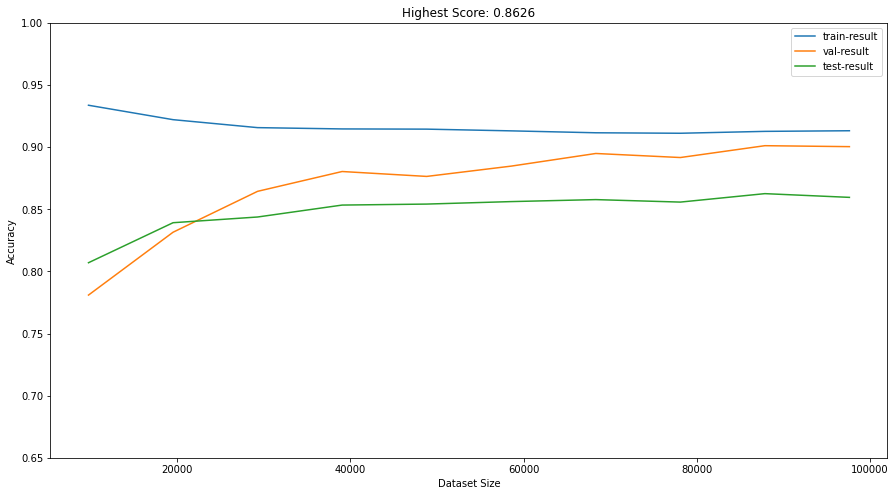

In [350]:
# feature 6: bow unibi 50k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9344
Gradient last 3: 0.0053


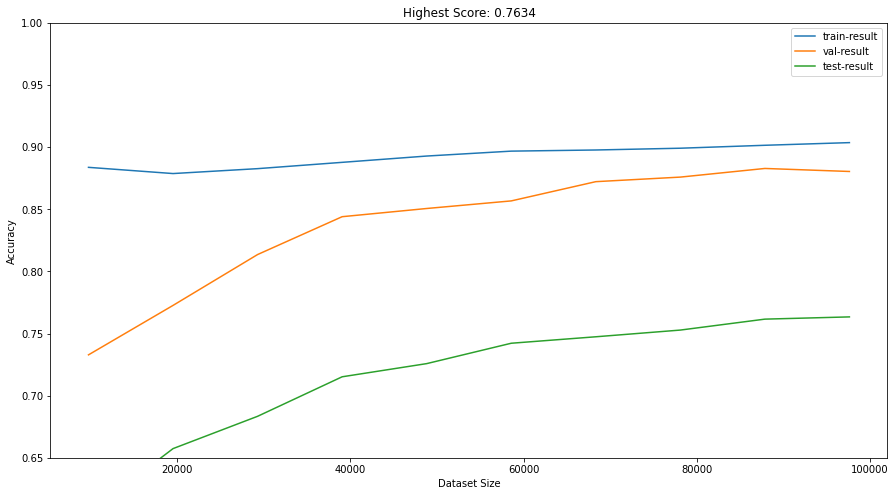

In [351]:
# feature 7: tfidf uni 50k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5961
Gradient last 3: 0.0021


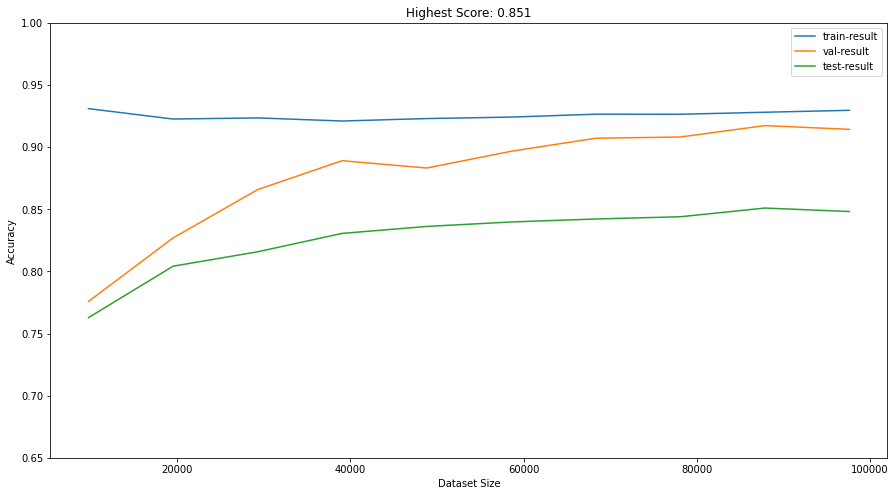

In [352]:
# feature 8: tfidf unibi 50k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 50000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5411
Gradient last 3: 0.0026


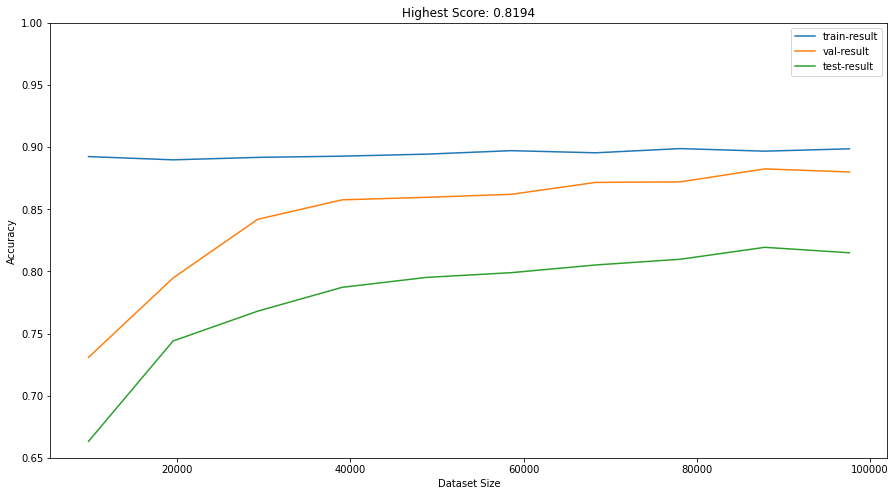

In [353]:
# feature 9: bow uni 100k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.1273
Gradient last 3: 0.0004


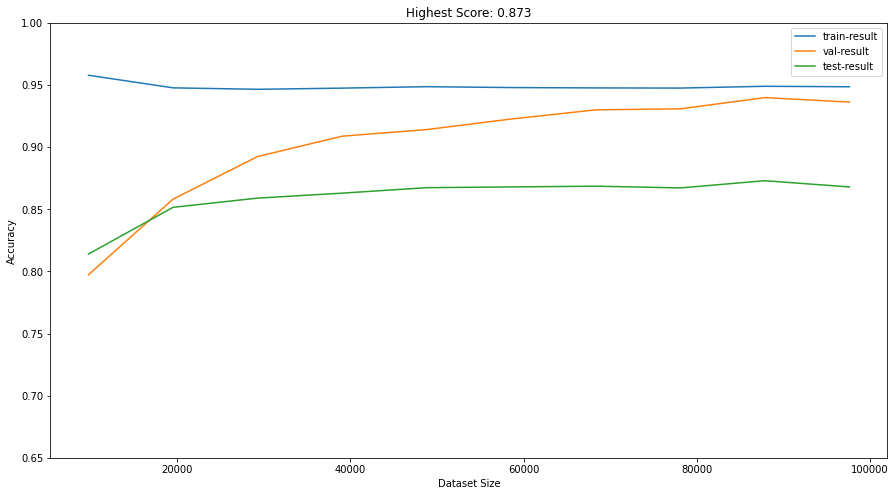

In [354]:
# feature 10: bow unibi 100k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9344
Gradient last 3: 0.0053


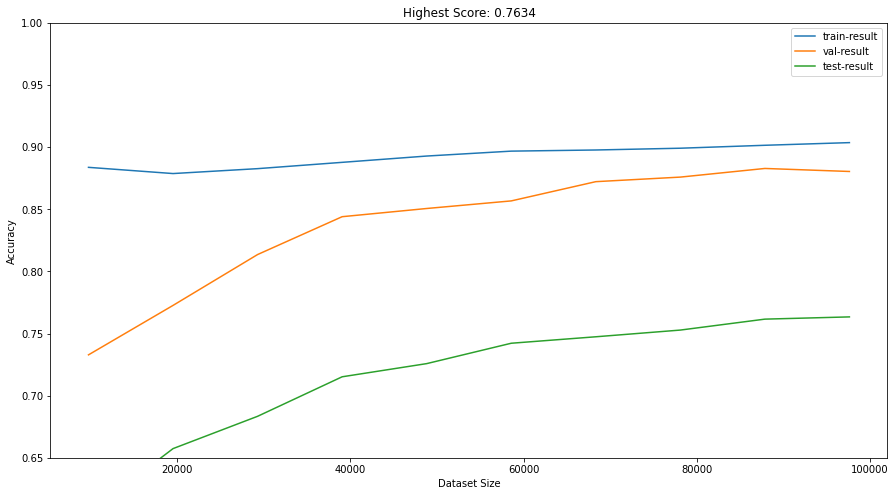

In [355]:
# feature 11: tfidf uni 100k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.4364
Gradient last 3: 0.0007


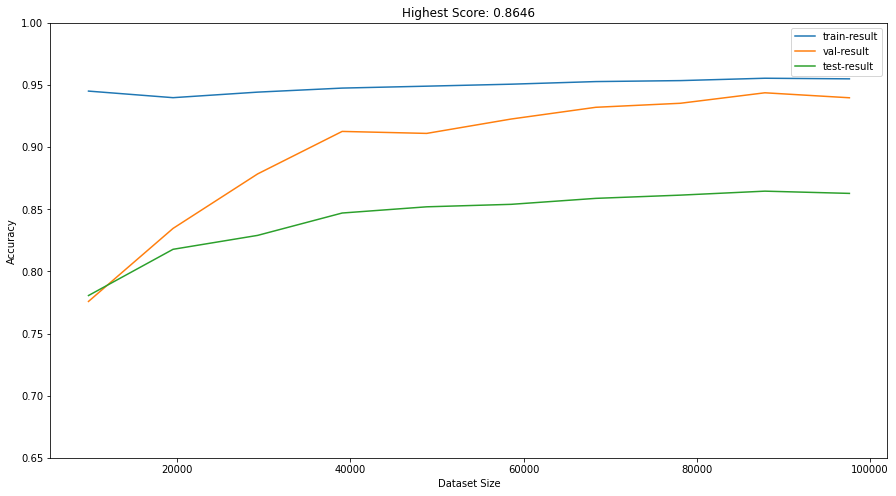

In [356]:
# feature 12: tfidf unibi 100k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 100000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.5411
Gradient last 3: 0.0026


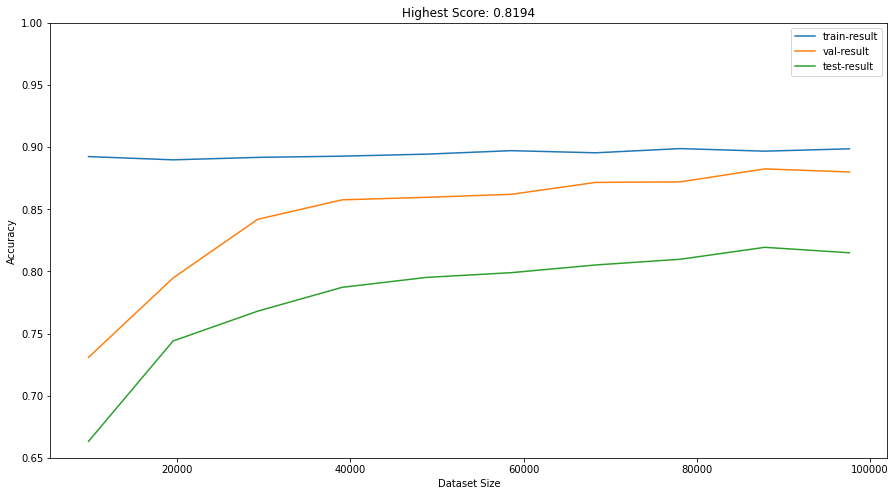

In [357]:
# feature 13: bow uni 150k

xArr, featureModel = feature_bowUni(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.6423
Gradient last 3: -0.0015


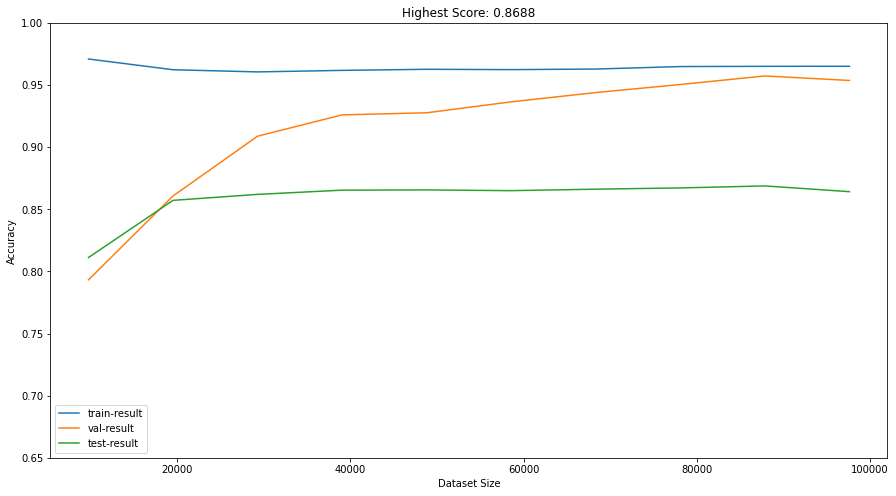

In [358]:
# feature 14: bow unibi 150k

xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9344
Gradient last 3: 0.0053


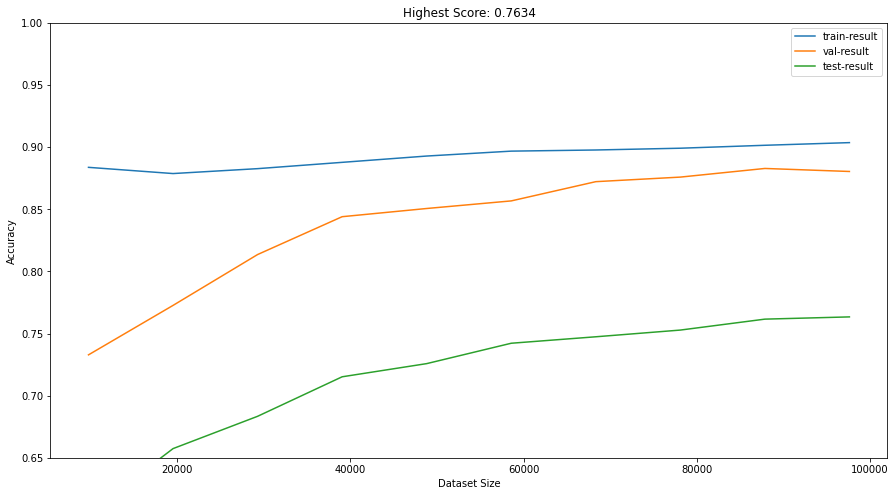

In [359]:
# feature 15: tfidf uni 150k

xArr, featureModel = feature_tfidfUni(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.0823
Gradient last 3: 0.0001


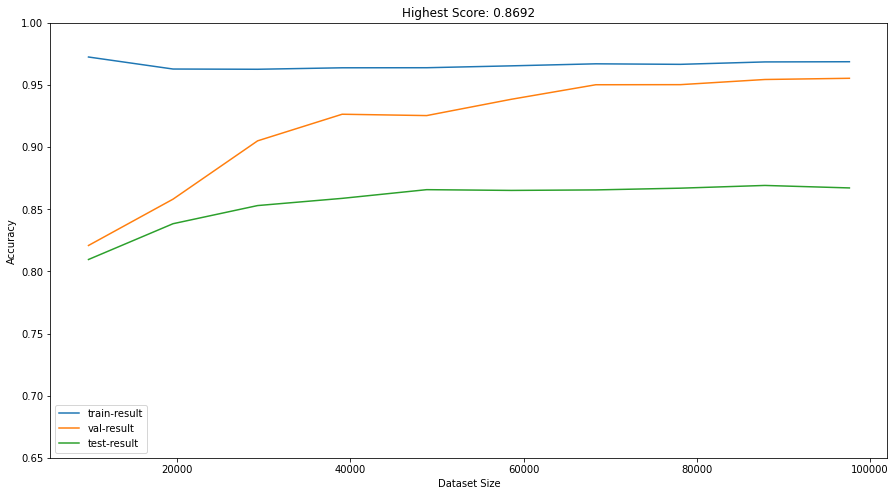

In [360]:
# feature 16: tfidf unibi 150k

xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [361]:
# search for best unibi features max

Result for 25000 max features
Correlation last 3: 0.4872
Gradient last 3: 0.0019


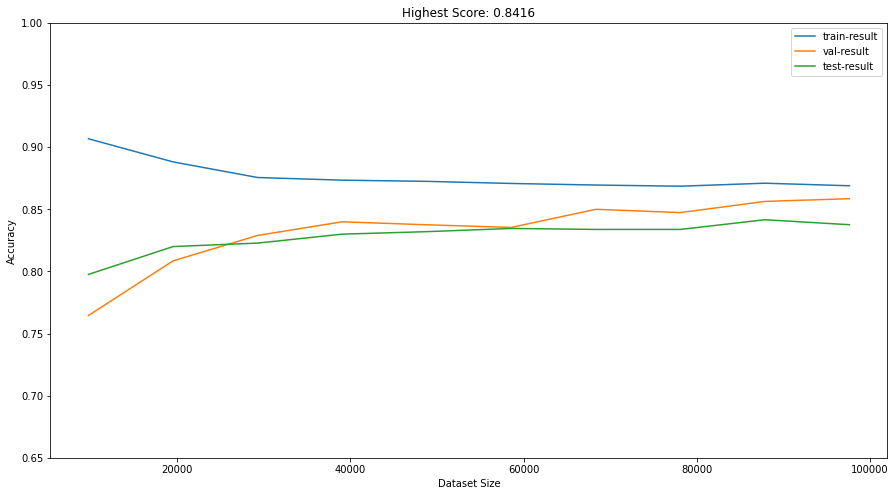

Result for 50000 max features
Correlation last 3: 0.5576
Gradient last 3: 0.0019


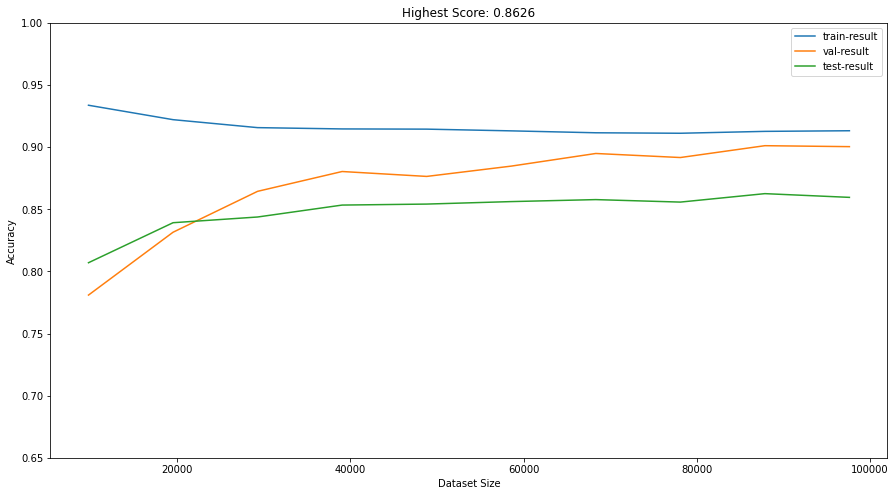

Result for 75000 max features
Correlation last 3: 0.4735
Gradient last 3: 0.0009


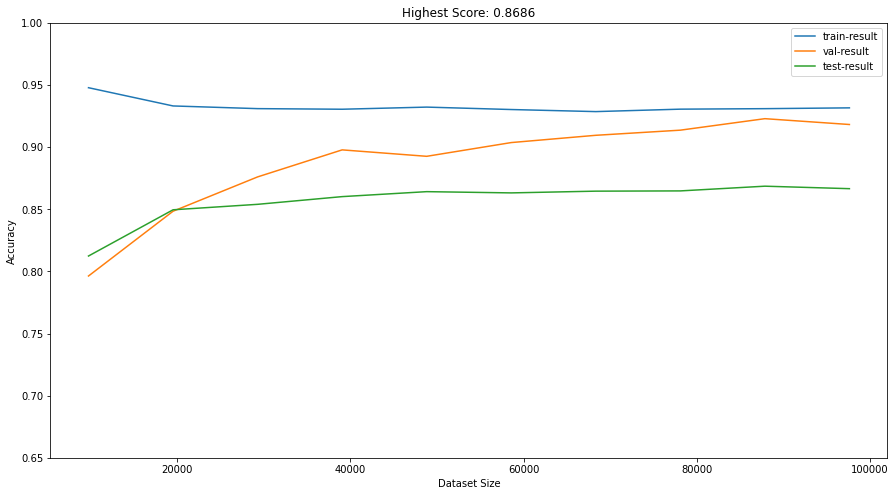

Result for 100000 max features
Correlation last 3: 0.1273
Gradient last 3: 0.0004


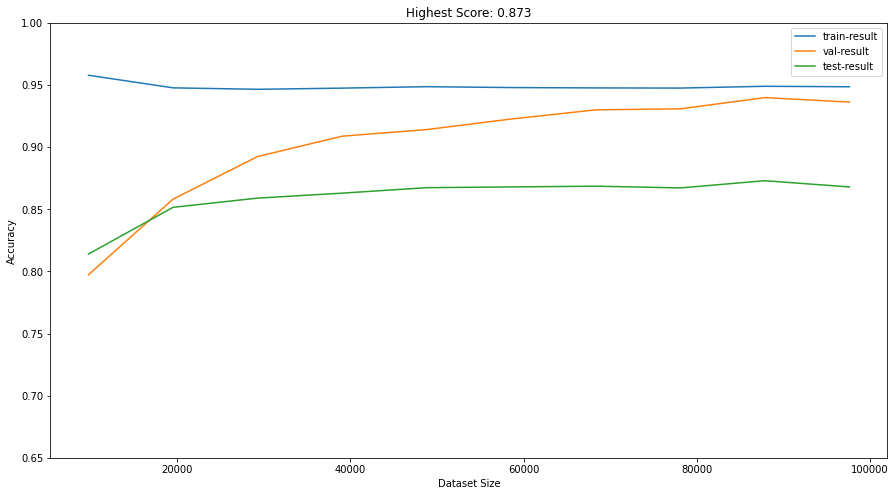

Result for 125000 max features
Correlation last 3: -0.4050
Gradient last 3: -0.0011


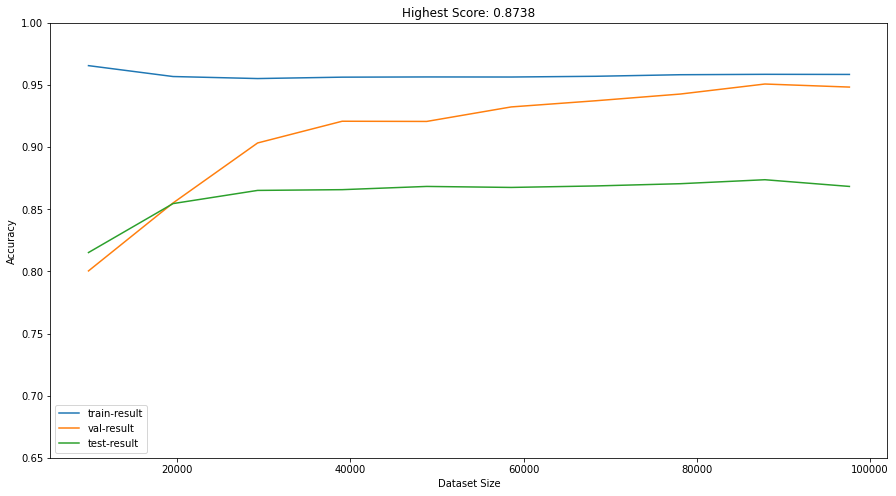

Result for 150000 max features
Correlation last 3: -0.6423
Gradient last 3: -0.0015


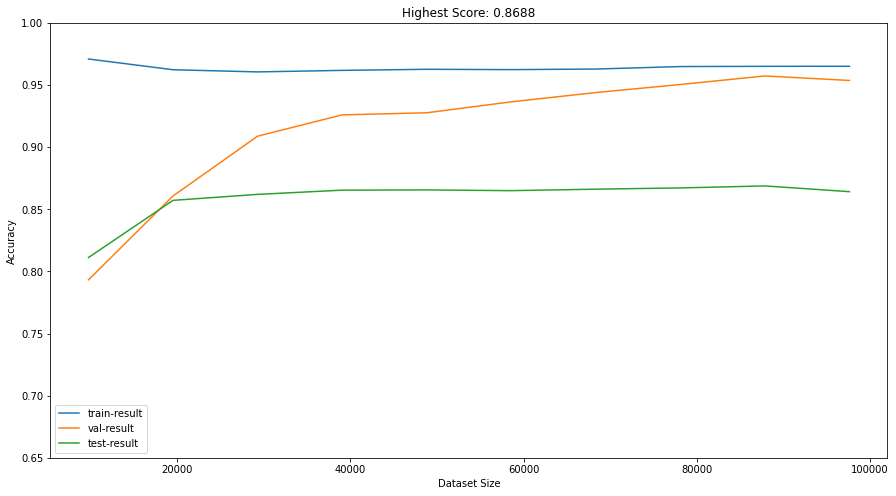

Result for 175000 max features
Correlation last 3: -0.3973
Gradient last 3: -0.0006


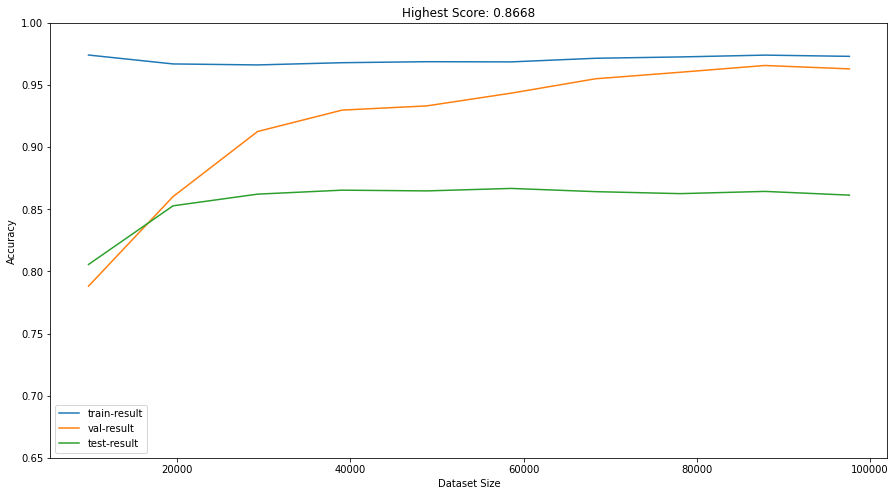

Result for 200000 max features
Correlation last 3: -0.3113
Gradient last 3: -0.0007


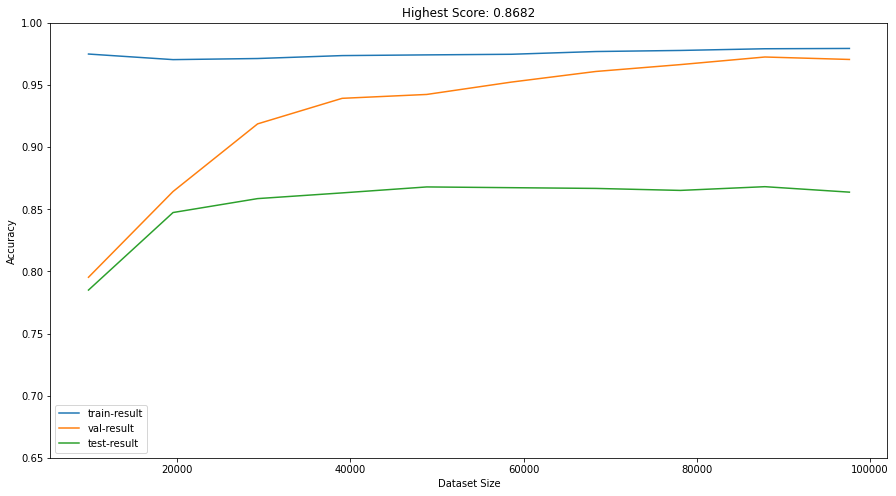

In [362]:
for r in range(25000, 200000+1, 25000):
    xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], r)
    yArr = tdf1['overall'].to_numpy()
    testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
    result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
    print("Result for {} max features".format(r))
    print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
    print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
    visualized_loopTesting(result)

Result for 25000 max features
Correlation last 3: 0.3839
Gradient last 3: 0.0012


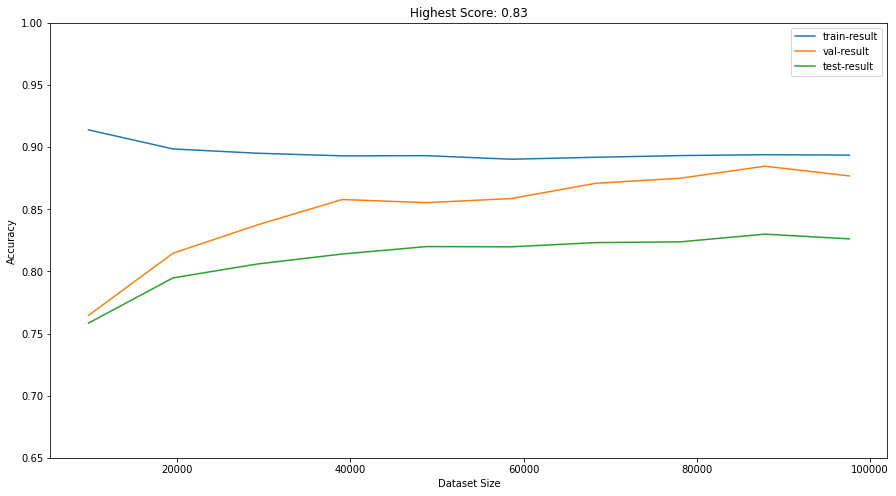

Result for 50000 max features
Correlation last 3: 0.5961
Gradient last 3: 0.0021


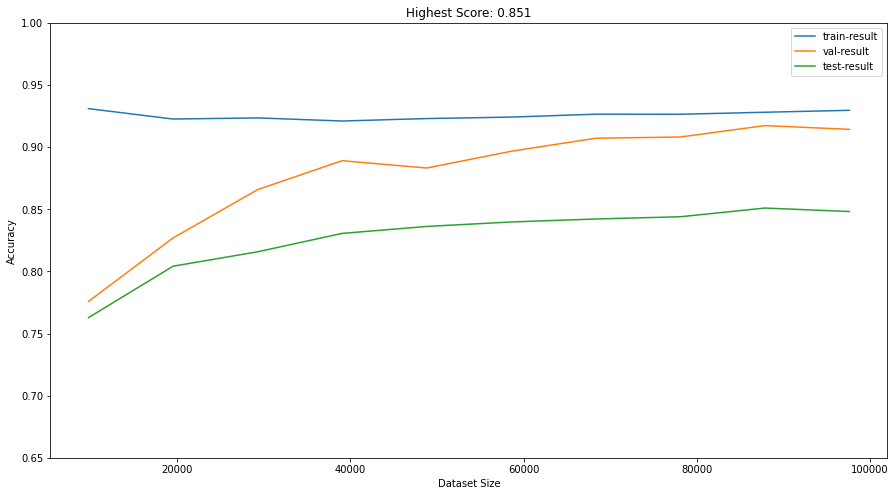

Result for 75000 max features
Correlation last 3: 0.3055
Gradient last 3: 0.0010


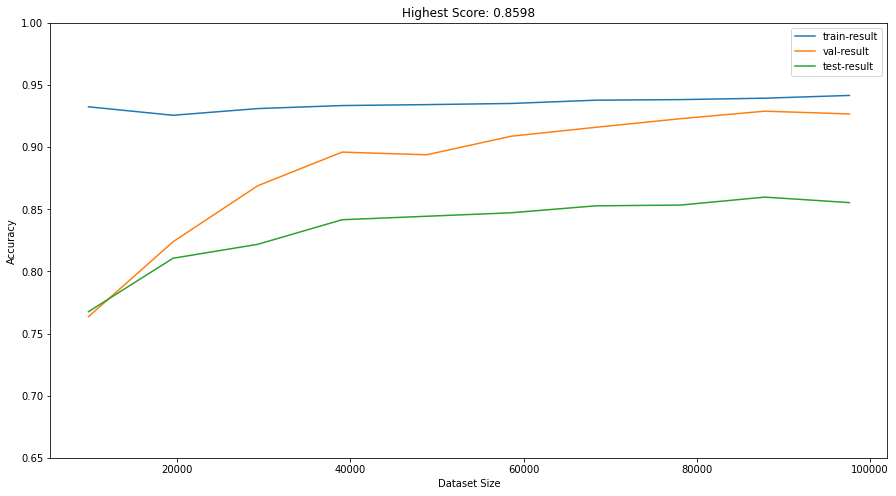

Result for 100000 max features
Correlation last 3: 0.4364
Gradient last 3: 0.0007


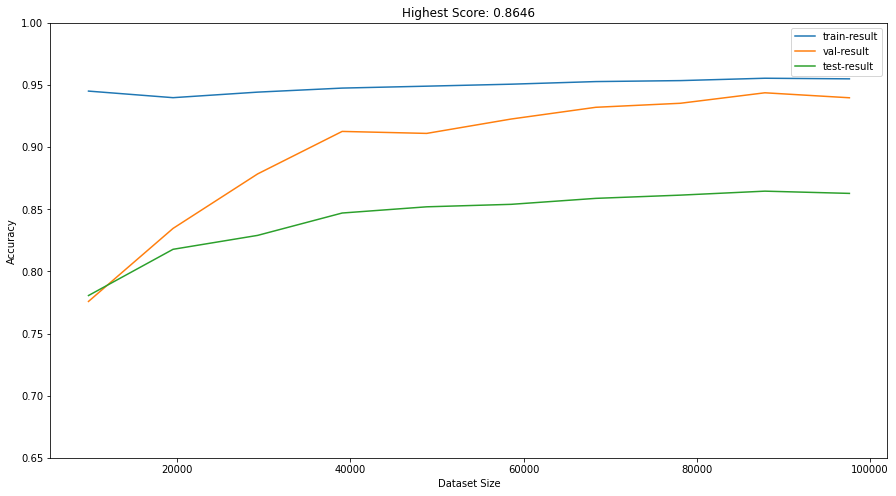

Result for 125000 max features
Correlation last 3: 0.6101
Gradient last 3: 0.0008


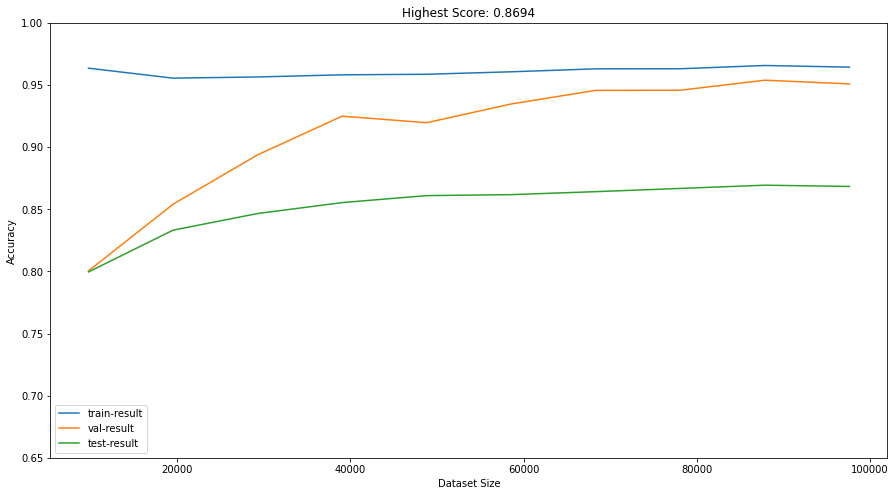

Result for 150000 max features
Correlation last 3: 0.0823
Gradient last 3: 0.0001


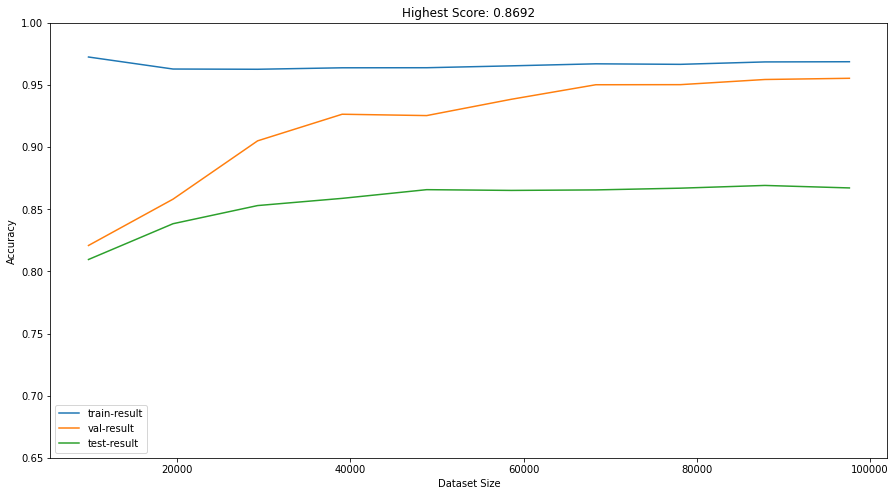

Result for 175000 max features
Correlation last 3: -0.6342
Gradient last 3: -0.0009


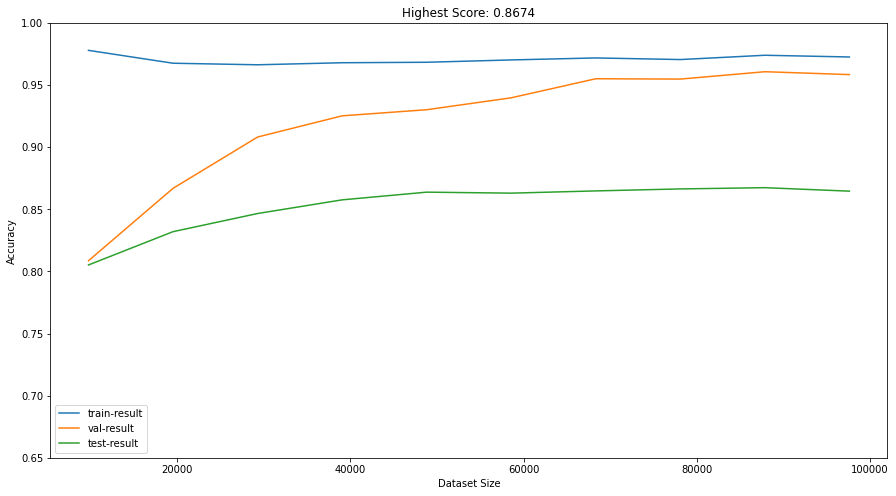

Result for 200000 max features
Correlation last 3: 0.2403
Gradient last 3: 0.0003


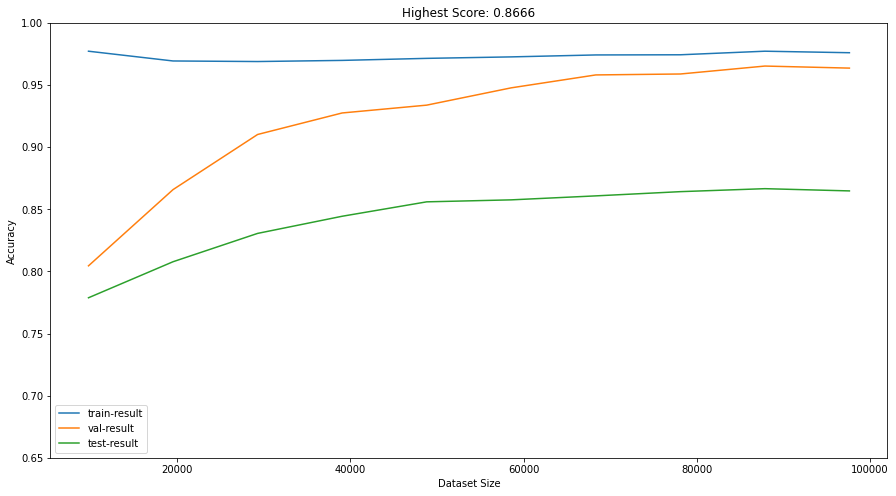

In [363]:
for r in range(25000, 200000+1, 25000):
    xArr, featureModel = feature_tfidfUniBi(tdf1['reviewText'], r)
    yArr = tdf1['overall'].to_numpy()
    testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()
    result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
    print("Result for {} max features".format(r))
    print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
    print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
    visualized_loopTesting(result)

In [373]:
# search for best base ml model

In [23]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt
    
tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

In [24]:
tdf1.shape

(97605, 3)

In [25]:
tdf2.shape

(5000, 3)

In [26]:
xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()

Correlation last 3: -0.3711
Gradient last 3: -0.0006


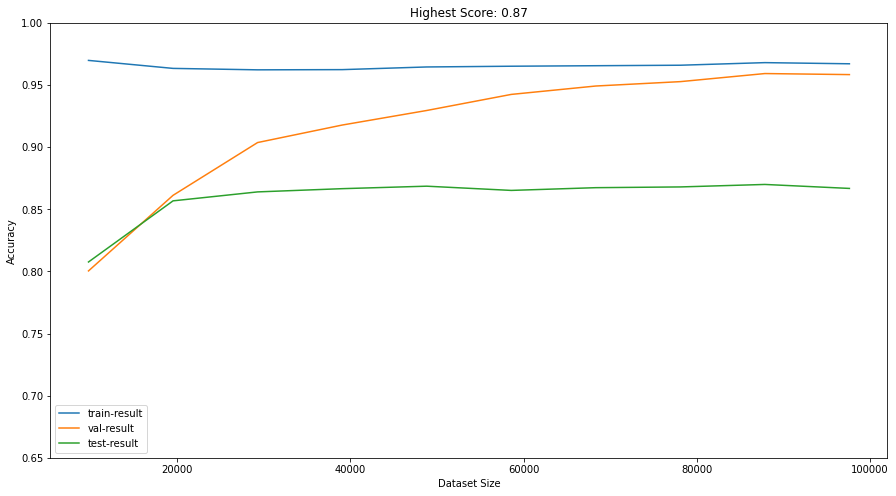

In [31]:
# option 1: naive bayes

nb_model = MultinomialNB()
result = loop_testing(nb_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: 0.9209
Gradient last 3: 0.0015


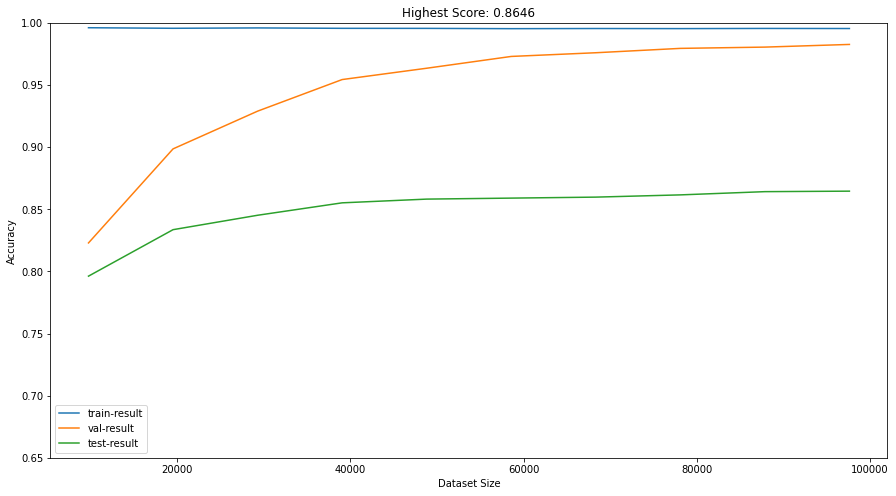

In [32]:
# option 2: linear svc

svc_model = LinearSVC()
result = loop_testing(svc_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.9549
Gradient last 3: -0.0013


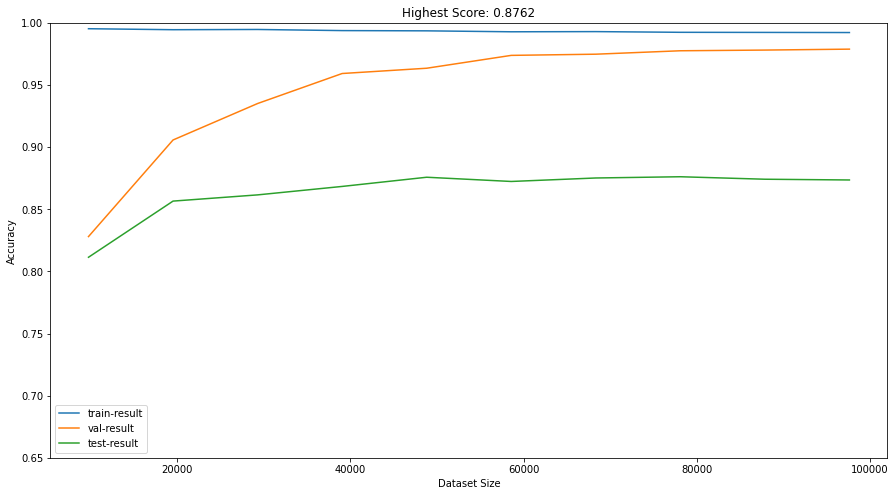

In [33]:
# option 3: linear sgd

sgd_model = SGDClassifier()
result = loop_testing(sgd_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

Correlation last 3: -0.7206
Gradient last 3: -0.0021


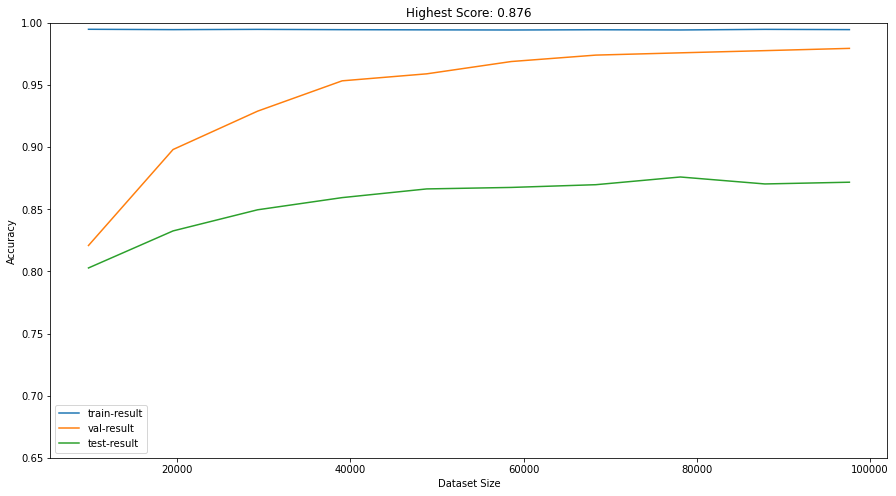

In [39]:
# option 4: linear logistic

log_model = LogisticRegression()
result = loop_testing(log_model, 10, xArr, yArr, testXArr, testYArr)
print("Correlation last 3: {:.4f}".format(correlation(list(result.keys())[-3:], [x[2] for x in result.values()][-3:])))
print("Gradient last 3: {:.4f}".format(gradient(range(1, 4), [x[2] for x in result.values()][-3:])))
visualized_loopTesting(result)

In [ ]:
# search best hyperparameter on best model on valid data (due to huge amount of data)
# 6hr and the gridsearchcv still running, so i decide to just take validation data for searching

In [22]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt
    
tdf1 = dfdataValid.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))

In [23]:
xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()

In [24]:
param_grid = {
    'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.0001, 0.00001],
    'class_weight': [None, 'balanced'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
}

In [31]:

sgd_model = SGDClassifier()
grid_search = GridSearchCV(sgd_model, param_grid, cv=5,
                          scoring="balanced_accuracy", n_jobs=-1)

grid_search.fit(xArr, yArr)

grid_search.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'penalty': 'elasticnet'}

In [96]:
data = []
for p, s in zip(cv_results["params"], cv_results["mean_test_score"]):
    p["mean_test_score"] = s
    data.append(p)
pd.DataFrame(data=data).sort_values(by=['mean_test_score'], ascending=False).reset_index()

,alpha,class_weight,learning_rate,loss,penalty,mean_test_score
155,0.00010,balanced,optimal,log_loss,elasticnet,0.621332
158,0.00010,balanced,optimal,log,elasticnet,0.619607
152,0.00010,balanced,optimal,hinge,elasticnet,0.619004
153,0.00010,balanced,optimal,log_loss,l2,0.616713
156,0.00010,balanced,optimal,log,l2,0.614013
...,...,...,...,...,...,...
475,0.00001,balanced,adaptive,epsilon_insensitive,l1,NaN
476,0.00001,balanced,adaptive,epsilon_insensitive,elasticnet,NaN
477,0.00001,balanced,adaptive,squared_epsilon_insensitive,l2,NaN
478,0.00001,balanced,adaptive,squared_epsilon_insensitive,l1,NaN


In [32]:
cv_results = grid_search.cv_results_
for mean_score, params in sorted(zip(cv_results["mean_test_score"], cv_results["params"]), key=lambda x: x[0], reverse=True):
    if not np.isnan(mean_score):
        print(mean_score, params)

0.5982494744287319 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'penalty': 'l1'}
0.5968814237868654 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'squared_hinge', 'penalty': 'l1'}
0.5922154905968682 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'penalty': 'elasticnet'}
0.5878438451741248 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'perceptron', 'penalty': 'l1'}
0.5862049529222826 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'perceptron', 'penalty': 'elasticnet'}
0.5858567068219852 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'hinge', 'penalty': 'l2'}
0.5852526582695385 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'penalty': 'l2'}
0.5836471992846675 {'alpha': 0.0001, 'class_weight': None, 'learning_rate': 'optimal', 'loss

In [33]:
# train whole data

In [34]:
grid_search.best_params_

{'alpha': 0.0001,
 'class_weight': 'balanced',
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'penalty': 'elasticnet'}

In [35]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_lemmatization(txt)
    txt = pipe_normalized(txt, 5)
    return txt
    
tdf1 = dfdataTrain.copy()
tdf2 = dfdataTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))

In [37]:
xArr, featureModel = feature_bowUniBi(tdf1['reviewText'], 150000)
yArr = tdf1['overall'].to_numpy()
testXArr, testYArr = featureModel.transform(tdf2['reviewText']), tdf2['overall'].to_numpy()

In [48]:

sgd_model = SGDClassifier(n_jobs=-1, alpha=0.0001, class_weight='balanced', learning_rate='optimal', loss='log_loss', penalty='elasticnet')
sgd_model.fit(xArr, yArr)

SGDClassifier(class_weight='balanced', loss='log_loss', n_jobs=-1,
              penalty='elasticnet')

              precision    recall  f1-score   support

    Positive       0.94      0.95      0.94     40449
     Neutral       0.40      0.39      0.39      3249
    Negative       0.72      0.70      0.71      6302

    accuracy                           0.88     50000
   macro avg       0.69      0.68      0.68     50000
weighted avg       0.88      0.88      0.88     50000



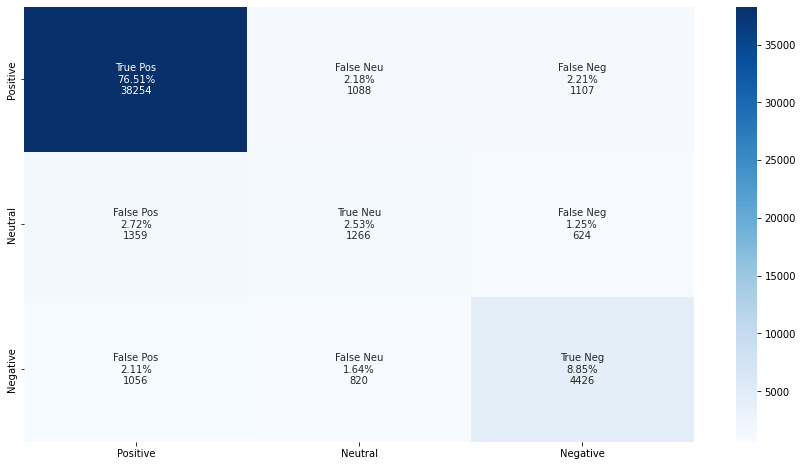

In [49]:
yHat = sgd_model.predict(testXArr)
show_result(yHat, testYArr)

In [50]:
# it manages to get a well balanced result compare to other baseline model
# to make it clear, off the record, i still managed to get higher accuracy using other model
# but the trade off is on the accuracy on the neutral side, however the goal of this model is to get balanced accuracy on positive, neutral and negative